# Notebook For Calculating Consumption Values

In [1]:
#Imports
import pandas
import xml.etree.ElementTree as ElementTree
import matplotlib.pyplot as plt
import numpy
from enum import Enum
from collections import namedtuple

In [2]:
#Base Params

COLOR = 'black'         #lightGray
BACKGROUND = "none"     #black
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR

plt.rcParams['axes.facecolor'] = BACKGROUND
plt.rcParams['figure.facecolor'] = BACKGROUND

## Preparing Research

In [5]:
stepsPerSec = 10

### Importing base emission values to dfBase

In [57]:
xmlDataBase = open('./preparingResearch//emissionBaseValues_Bckp.xml', 'r').read()  # Read file
rootBase = ElementTree.XML(xmlDataBase)  # Parse XML

colsBase = []
dataBase = []
for i in rootBase:
    line = []
    for fuelInfo in i:
        # print(i.attrib["time"] + " " + fuelinfo.attrib["id"] + " " + str(fuelinfo.attrib["fuel"]))
        line.append(float(fuelInfo.attrib["fuel"]) / stepsPerSec)

        if (fuelInfo.attrib["id"] not in colsBase):
            colsBase.append(fuelInfo.attrib["id"])
    dataBase.append(line)

dfBase = pandas.DataFrame(dataBase)
dfBase.columns = colsBase
# print(dfBase)


### Total consumption of each car

Text(0.5, 1.0, 'Total consumption of each car')

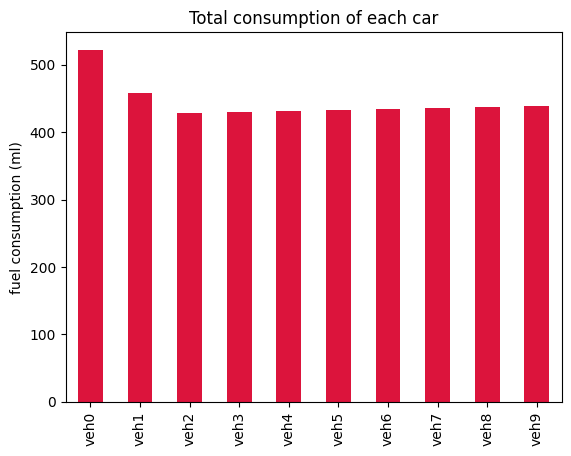

In [58]:
baseSum = dfBase.sum(0)
# print(summed)
baseSum.plot(kind="bar", color="crimson")
plt.ylabel("fuel consumption (ml)")
plt.title("Total consumption of each car")

### Importing emission scaling values to dfScale

In [59]:
xmlDataScale = open("./preparingResearch/emissionScaleValues_Bckp.xml", "r").read()
rootScale = ElementTree.XML(xmlDataScale)

colsScale = []
dataScale = []
for i in rootScale:
    line = []
    for scaleInfo in i:
        line.append(float(scaleInfo.attrib["scaling"]))

        if (scaleInfo.attrib["id"] not in colsScale):
            colsScale.append(scaleInfo.attrib["id"])
    dataScale.append(line)
dfScale = pandas.DataFrame(dataScale)
dfScale.columns = colsScale
# print(dfScale)

### Total scaling values of each car

<AxesSubplot: >

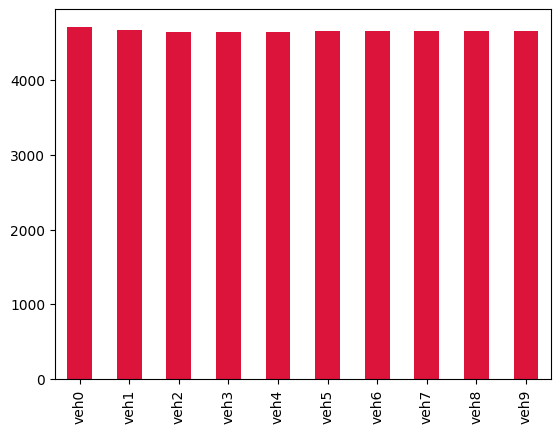

In [60]:
scaledSum = dfScale.sum(0)
# print(scaledSum)
scaledSum.plot(kind="bar", color="crimson")

### Scaling base consumptions for simulated savings

In [61]:
vehicles = dfBase.columns
rowsBase = len(dfBase.index)
rowsScale = len(dfScale.index)
rowsSmaller = rowsBase if rowsBase < rowsScale else rowsScale

dataBaseScaled = []

for i in range(rowsSmaller):
    line = []
    for veh in vehicles:
        b = dfBase[veh][i]
        s = dfScale[veh][i]
        bsd = b*s
        line.append(bsd)
    dataBaseScaled.append(line)

dfBaseScaled = pandas.DataFrame(dataBaseScaled, columns=vehicles)

### Total consumed fuel of each car (controlled, ml)

veh0    479.08960
veh1    420.75900
veh2    389.06830
veh3    390.21000
veh4    391.34475
veh5    392.69200
veh6    393.82335
veh7    394.95725
veh8    396.29005
veh9    397.41460
dtype: float64


Text(0.5, 1.0, 'Scaled total consumption of controlled cars')

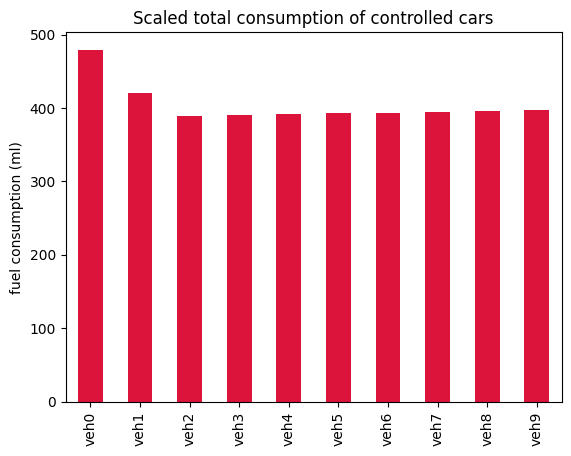

In [62]:
baseScaledSum = dfBaseScaled.sum(0)
print(baseScaledSum)
baseScaledSum.plot(kind="bar", color="crimson")
plt.ylabel("fuel consumption (ml)")
plt.title("Scaled total consumption of controlled cars")

### Importing emission values of uncontrolled cars 

In [63]:
xmlDataUnc = open('./preparingResearch/emissionBaseValues_Uncontrolled_Bckp.xml', 'r').read()  # Read file
rootUnc = ElementTree.XML(xmlDataUnc)  # Parse XML

colsUnc = []
dataUnc = []
for i in rootUnc:
    line = []
    for fuelInfo in i:
        # print(i.attrib["time"] + " " + fuelinfo.attrib["id"] + " " + str(fuelinfo.attrib["fuel"]))
        line.append(float(fuelInfo.attrib["fuel"]) / stepsPerSec)

        if (fuelInfo.attrib["id"] not in colsUnc):
            colsUnc.append(fuelInfo.attrib["id"])
    dataUnc.append(line)

dfUnc = pandas.DataFrame(dataUnc)
dfUnc.columns = colsUnc

### Total consumed fuel of each car (uncontrolled, ml)

Text(0.5, 1.0, 'Total consumption uncontrolled cars')

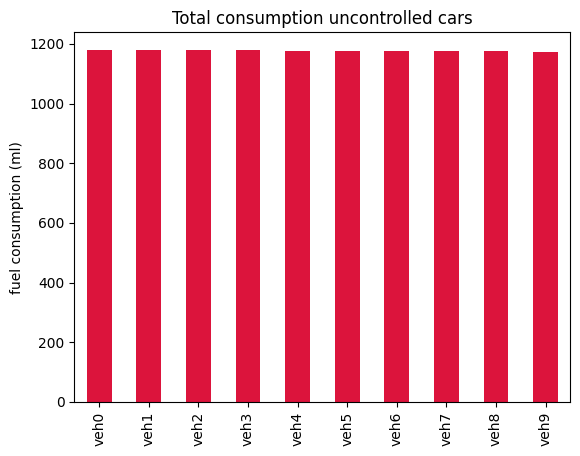

In [64]:
uncSum = dfUnc.sum(0)
# print(summed)
uncSum.plot(kind="bar", color="crimson")
plt.ylabel("fuel consumption (ml)")
plt.title("Total consumption uncontrolled cars")
# ax = plt.gca()
# ax.set_facecolor('xkcd:salmon')

## Final Thesis Research

### Function For Calculating Fuel Consumption

In [3]:
def getDistanceTraveledInKms(tripinfoFileName):
    dataFrame = pandas.read_xml(tripinfoFileName)
    distancesInKms = dataFrame["routeLength"] / 1000
    elements = len(distancesInKms)
    average = distancesInKms.sum() / elements
    return average

In [4]:
FuelType = namedtuple("FuelType", "pathName density")
class TYPE(Enum):
    PETROL = FuelType("Petrol", 0.775)      # g/(cm^3), source: https://mol.hu/images/pdf/Vallalatiugyfeleknek/Uzemanyagok/mol_motorbenzinek_termeklap.pdf
    DIESEL = FuelType("Diesel", 0.8558)     # g/(cm^3), source: https://www.sciencedirect.com/topics/engineering/diesel-fuel
    ELECTRIC = FuelType("Electric", 0)

In [5]:
class TRIPINFO(Enum):
    CONTROLLED = "./simulationResults/tripinfo_controlled.xml"
    UNCONTROLLED = "./simulationResults/tripinfo_uncontrolled.xml"

In [6]:
def readAndCalculateFuelConsumption(baseValuesFile, scalingValuesFile, stepsInOneSec, type, tripinfoFile):
    filePath = "./simulationResults_Backup_" + type.value.pathName + "_With1000Steps5StepsPerSecAndChangeEvery50StepAt30Speed/"
    # Reading in base values
    baseValuesFileWithPath = filePath + baseValuesFile
    baseDataAsXml = open(baseValuesFileWithPath, 'r').read()
    rootBaseValues = ElementTree.XML(baseDataAsXml)

    baseColumns = []
    baseData = []
    for element in rootBaseValues:
        line = []
        for fuelInfo in element:
            if (type.name == TYPE.ELECTRIC.name):
                line.append(float(fuelInfo.attrib["electricity"])*(1/stepsInOneSec))
            else:
                line.append(float(fuelInfo.attrib["fuel"])*(1/stepsInOneSec))
            
            if (fuelInfo.attrib["id"] not in baseColumns):
                baseColumns.append(fuelInfo.attrib["id"])
        baseData.append(line)

    baseDataFrame = pandas.DataFrame(baseData)
    baseDataFrame.columns = baseColumns

    # Reading in scaled values
    scalingValuesFileWithPath = filePath + scalingValuesFile
    scalingDataAsXml = open(scalingValuesFileWithPath, 'r').read()
    rootScalingValues = ElementTree.XML(scalingDataAsXml)

    scalingColumns = []
    scalingData = []
    for element in rootScalingValues:
        line = []
        for scalingInfo in element:
            line.append(float(scalingInfo.attrib["scaling"]))

            if (scalingInfo.attrib["id"] not in scalingColumns):
                scalingColumns.append(scalingInfo.attrib["id"])
        scalingData.append(line)

    scalingDataFrame = pandas.DataFrame(scalingData)
    scalingDataFrame.columns = scalingColumns

    # Creating result dataFrame
    vehicles = baseDataFrame.columns
    rowsInBase = len(baseDataFrame.index)
    rowsInScaling = len(scalingDataFrame.index)

    rowsInSmaller = rowsInBase if rowsInBase < rowsInScaling else rowsInScaling

    scaledData = []

    for i in range(rowsInSmaller):
        line = []
        for veh in vehicles:
            base = baseDataFrame[veh][i]
            scaling = scalingDataFrame[veh][i]
            scaled = base*scaling
            line.append(scaled)
        scaledData.append(line)

    scaledDataFrame = pandas.DataFrame(scaledData, columns = vehicles)
    scaledValuesSum = scaledDataFrame.sum(0)

    if (type.name == TYPE.ELECTRIC.name):
        scaledValuesAsKWh = scaledValuesSum / 1000
        consumptionOver100Km = scaledValuesAsKWh * (100/getDistanceTraveledInKms(tripinfoFile.value))
    else:
        scaledValuesAsGrams = scaledValuesSum / 1000
        scaledValuesAsCm3 = scaledValuesAsGrams / type.value.density
        scaledValuesAsLitre = scaledValuesAsCm3 / 1000
        consumptionOver100Km = scaledValuesAsLitre * (100/getDistanceTraveledInKms(tripinfoFile.value))

    return consumptionOver100Km

In [7]:
calcTestFrameOne = readAndCalculateFuelConsumption(
    "emissionBaseValues_Uncontrolled.xml",
    "emissionScalingValues_Uncontrolled.xml",
    5,
    TYPE.DIESEL,
    TRIPINFO.UNCONTROLLED
)
calcTestFrameOne.sum()/len(calcTestFrameOne)

2.264922785697593

In [8]:
calcTestFrameTwo = readAndCalculateFuelConsumption(
    "emissionBaseValues_Controlled.xml",
    "emissionScalingValues_Controlled.xml",
    5,
    TYPE.DIESEL,
    TRIPINFO.CONTROLLED
)
calcTestFrameTwo.sum()/len(calcTestFrameTwo)

2.089956210262948

### Function For Creating Graph With Different Slow-Down Values (Shows Best Slow-Down Percentage)

In [17]:
from cProfile import label


def printOneGraphOfConsumptions(dataFrame, xLabel, yLabel, title):

    plt.scatter(
        [0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,3,3,4,4,4,4,4,4,4,4,4,4,5,5,5,5,5,5,5,5,5,5,6,6,6,6,6,6,6,6,6,6,7,7,7,7,7,7,7,7,7,7,8,8,8,8,8,8,8,8,8,8,9,9,9,9,9,9,9,9,9,9],
        dataFrame,
        alpha = 0.3
    )

    plt.plot(
        dataFrame,
        # label = ["Jármű%d"%i for i in range(0, 10)]
        label = ["$Jármű_{%d}$"%i for i in range(0,10)]
    )

    plt.xlabel(xLabel)
    plt.xticks(rotation = 45)
    plt.ylabel(yLabel)
    plt.legend()
    plt.title(title)

##### Get all Slow-Down Simulation Results

In [10]:
resultsUncontrolled = readAndCalculateFuelConsumption(
    "emissionBaseValues_Uncontrolled.xml",
    "emissionScalingValues_Uncontrolled.xml",
    5,
    TYPE.PETROL,
    TRIPINFO.UNCONTROLLED
)
resultsAt99 = readAndCalculateFuelConsumption(
    "emissionBaseValues_Controlled_SlowFactorAt_99_Percentage.xml",
    "emissionScalingValues_Controlled_SlowFactorAt_99_Percentage.xml",
    5,
    TYPE.PETROL,
    TRIPINFO.CONTROLLED
)
resultsAt95 = readAndCalculateFuelConsumption(
    "emissionBaseValues_Controlled_SlowFactorAt_95_Percentage.xml",
    "emissionScalingValues_Controlled_SlowFactorAt_95_Percentage.xml",
    5,
    TYPE.PETROL,
    TRIPINFO.CONTROLLED
)
resultsAt92 = readAndCalculateFuelConsumption(
    "emissionBaseValues_Controlled_SlowFactorAt_92_Percentage.xml",
    "emissionScalingValues_Controlled_SlowFactorAt_92_Percentage.xml",
    5,
    TYPE.PETROL,
    TRIPINFO.CONTROLLED
)
resultsAt91 = readAndCalculateFuelConsumption(
    "emissionBaseValues_Controlled_SlowFactorAt_91_Percentage.xml",
    "emissionScalingValues_Controlled_SlowFactorAt_91_Percentage.xml",
    5,
    TYPE.PETROL,
    TRIPINFO.CONTROLLED
)
resultsAt90 = readAndCalculateFuelConsumption(
    "emissionBaseValues_Controlled_SlowFactorAt_90_Percentage.xml",
    "emissionScalingValues_Controlled_SlowFactorAt_90_Percentage.xml",
    5,
    TYPE.PETROL,
    TRIPINFO.CONTROLLED
)
resultsAt85 = readAndCalculateFuelConsumption(
    "emissionBaseValues_Controlled_SlowFactorAt_85_Percentage.xml",
    "emissionScalingValues_Controlled_SlowFactorAt_85_Percentage.xml",
    5,
    TYPE.PETROL,
    TRIPINFO.CONTROLLED
)
resultsAt80 = readAndCalculateFuelConsumption(
    "emissionBaseValues_Controlled_SlowFactorAt_80_Percentage.xml",
    "emissionScalingValues_Controlled_SlowFactorAt_80_Percentage.xml",
    5,
    TYPE.PETROL,
    TRIPINFO.CONTROLLED
)
resultsAt70 = readAndCalculateFuelConsumption(
    "emissionBaseValues_Controlled_SlowFactorAt_70_Percentage.xml",
    "emissionScalingValues_Controlled_SlowFactorAt_70_Percentage.xml",
    5,
    TYPE.PETROL,
    TRIPINFO.CONTROLLED
)
resultsAt60 = readAndCalculateFuelConsumption(
    "emissionBaseValues_Controlled_SlowFactorAt_60_Percentage.xml",
    "emissionScalingValues_Controlled_SlowFactorAt_60_Percentage.xml",
    5,
    TYPE.PETROL,
    TRIPINFO.CONTROLLED
)

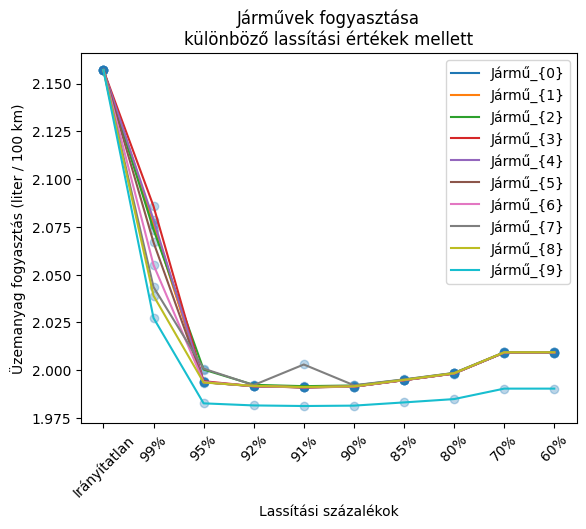

In [18]:
everythingDataFrame = pandas.DataFrame(
    [resultsUncontrolled, resultsAt99, resultsAt95, resultsAt92, resultsAt91, resultsAt90, resultsAt85, resultsAt80, resultsAt70, resultsAt70],
    index = ['Irányítatlan', '99%', '95%', '92%', '91%', '90%', '85%', '80%', '70%', '60%']
)

printOneGraphOfConsumptions(everythingDataFrame, "Lassítási százalékok", "Üzemanyag fogyasztás (liter / 100 km)", "Járművek fogyasztása\nkülönböző lassítási értékek mellett")

### Function For Creating Graphs Comparing Two Simulations (Best Used For Comparing Uncontrolled And Controlled)

In [43]:
def printComparisonGraph(uncontrolledValues, controlledValues, xLabel, yLabel, title):

    labels = ["Irányítatlan", "Vezérelt"]

    averages = [uncontrolledValues, controlledValues]

    x = numpy.arange(len(labels))       # label locations
    width = 0.5                        # width of labels

    figure, axis = plt.subplots()
    uncontrolledBars = axis.bar(0, uncontrolledValues, width, label = "Uncontrolled Average", color = (0.4, 0.4, 0.4, 1))
    controlledBars = axis.bar(0.6, controlledValues, width, label = "Controlled Average", color = (0.6, 0, 0, 1))

    axis.set_ylabel(yLabel)
    axis.set_title(title)
    axis.set_xticks([0, 0.6], labels)
    # axis.legend()

    axis.bar_label(uncontrolledBars, padding = -20)
    axis.bar_label(controlledBars, padding = -20)

    figure.tight_layout()

    plt.show()


In [16]:
valuesForGraphUncontrolled = readAndCalculateFuelConsumption (
        "emissionBaseValues_Uncontrolled_Savings_At_0.xml",
        "emissionScalingValues_Uncontrolled_Savings_At_0.xml",
        5,
        TYPE.PETROL,
        TRIPINFO.UNCONTROLLED
    )
valuesForGraphControlled = readAndCalculateFuelConsumption (
        "emissionBaseValues_Controlled_Savings_At_0.xml",
        "emissionScalingValues_Controlled_Savings_At_0.xml",
        5,
        TYPE.PETROL,
        TRIPINFO.CONTROLLED
    )

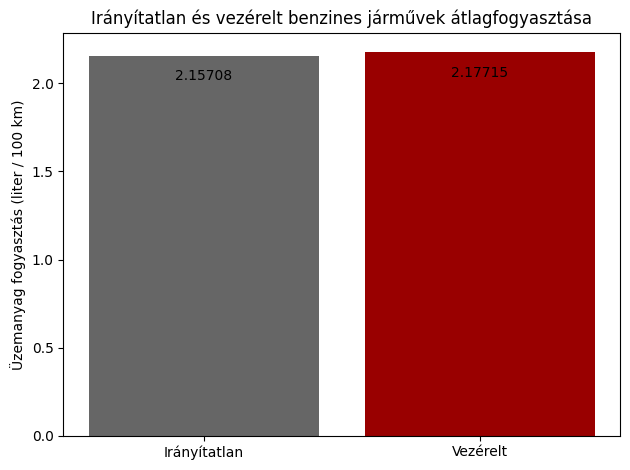

In [44]:
printComparisonGraph(
    sum(valuesForGraphUncontrolled) / len(valuesForGraphUncontrolled),
    sum(valuesForGraphControlled) / len(valuesForGraphControlled),
    "Average consumption of vehicles",
    "Üzemanyag fogyasztás (liter / 100 km)",
    "Irányítatlan és vezérelt benzines járművek átlagfogyasztása",
)

### Function For Creating Graph Comparing All Vehicle Types, Scaled At Optimal Savings

In [46]:
def createGraphComparingAllTypesScaledAtOptimalSavings(
    uncontrolledPetrol, controlledPetrol, uncontrolledDiesel, controlledDiesel, uncontrolledElectric, controlledElectric,
    title, yLabel, barLegends, barLabels    
):
    # xLabel, yLabel and title not needed, will be self explanatory from function name and not changeable
    labels = barLabels # Petrol, Diesel, Electric
    uncontrolledAverages = [uncontrolledPetrol, uncontrolledDiesel, uncontrolledElectric]
    controlledAverages = [controlledPetrol, controlledDiesel, controlledElectric]

    x = numpy.arange(len(labels))   # label locations
    width = 0.35                    # width of bars
    
    figure, axis = plt.subplots()
    uncontrolledBars = axis.bar(x - width/2, uncontrolledAverages, width, label=barLegends[0], color=(0.4, 0.4, 0.4, 1))   # Uncontrolled Average
    controlledBars = axis.bar(x + width/2, controlledAverages, width, label=barLegends[1], color=(0.6, 0, 0, 1))           # Controlled Average

    axis.set_ylabel(yLabel)     # Fuel Consumption on 100 km (litre and kWh respectively)
    axis.set_title(title) # Consumption of controlled and uncontrolled cars, grouped by type
    axis.set_xticks(x, labels)
    axis.legend()

    axis.bar_label(uncontrolledBars, padding = 3)
    axis.bar_label(controlledBars, padding = 3)
    
    figure.tight_layout()

    plt.show()

In [25]:
uncontrolledPetrolValues = readAndCalculateFuelConsumption(
    "emissionBaseValues_Uncontrolled.xml",
    "emissionScalingValues_Uncontrolled.xml",
    5,
    TYPE.PETROL,
    TRIPINFO.UNCONTROLLED
)
controlledPetrolValues = readAndCalculateFuelConsumption(
    "emissionBaseValues_Controlled.xml",
    "emissionScalingValues_Controlled.xml",
    5,
    TYPE.PETROL,
    TRIPINFO.CONTROLLED
)
uncontrolledDieselValues = readAndCalculateFuelConsumption(
    "emissionBaseValues_Uncontrolled.xml",
    "emissionScalingValues_Uncontrolled.xml",
    5,
    TYPE.DIESEL,
    TRIPINFO.UNCONTROLLED
)
controlledDieselValues = readAndCalculateFuelConsumption(
    "emissionBaseValues_Controlled.xml",
    "emissionScalingValues_Controlled.xml",
    5,
    TYPE.DIESEL,
    TRIPINFO.CONTROLLED
)
uncontrolledElectricValues = readAndCalculateFuelConsumption(
    "emissionBaseValues_Uncontrolled.xml",
    "emissionScalingValues_Uncontrolled.xml",
    5,
    TYPE.ELECTRIC,
    TRIPINFO.UNCONTROLLED
)
controlledElectricValues = readAndCalculateFuelConsumption(
    "emissionBaseValues_Controlled.xml",
    "emissionScalingValues_Controlled.xml",
    5,
    TYPE.ELECTRIC,
    TRIPINFO.CONTROLLED
)

uncontrolledPetrolAvg = sum(uncontrolledPetrolValues) / len(uncontrolledPetrolValues)
controlledPetrolAvg = sum(controlledPetrolValues) / len(uncontrolledPetrolValues)
uncontrolledDieselAvg = sum(uncontrolledDieselValues) / len(uncontrolledDieselValues)
controlledDieselAvg = sum(controlledDieselValues) / len(controlledDieselValues)
uncontrolledElectricAvg = sum(uncontrolledElectricValues) / len(uncontrolledElectricValues)
controlledElectricAvg = sum(controlledElectricValues) / len(controlledElectricValues)

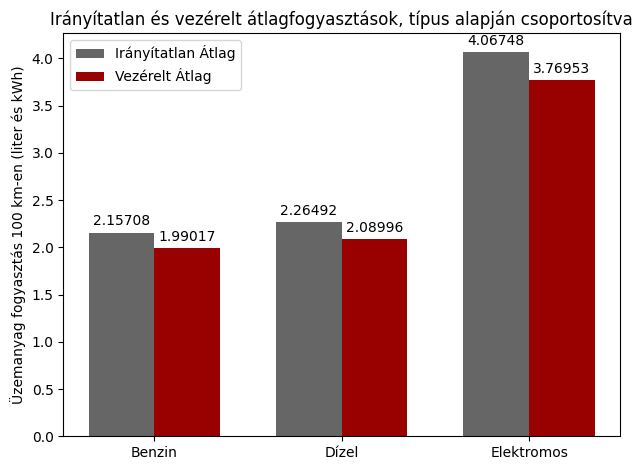

In [47]:
createGraphComparingAllTypesScaledAtOptimalSavings(
    uncontrolledPetrolAvg, controlledPetrolAvg, uncontrolledDieselAvg, controlledDieselAvg, uncontrolledElectricAvg, controlledElectricAvg,
    "Irányítatlan és vezérelt átlagfogyasztások, típus alapján csoportosítva", "Üzemanyag fogyasztás 100 km-en (liter és kWh)", ["Irányítatlan Átlag", "Vezérelt Átlag"], ["Benzin", "Dízel", "Elektromos"]
)

## Old code

In [191]:
def readCalculateAndPrintFuelConsumption_Normal(baseValuesFile, scalingValuesFile, plotName, stepsInOneSec):   # TODO: add param for distance

    # Reading in base values
    baseValuesFileWithPath = './simulationResults_Backup_Petrol_With1000Steps5StepsPerSecAndChangeEvery50StepAt30Speed/' + baseValuesFile  # TODO: change path variable
    baseDataAsXml = open(baseValuesFileWithPath, 'r').read()
    rootBaseValues = ElementTree.XML(baseDataAsXml)

    baseColumns = []
    baseData = []
    for i in rootBaseValues:
        line = []
        for fuelInfo in i:
            line.append(float(fuelInfo.attrib["fuel"]) / stepsInOneSec )  # Fuel value is calculated in step, so we have to divide it by steps in one sec

            if (fuelInfo.attrib["id"] not in baseColumns):
                baseColumns.append(fuelInfo.attrib["id"])
        baseData.append(line)
    
    baseDataFrame = pandas.DataFrame(baseData)
    baseDataFrame.columns = baseColumns

    # Reading in scaled values
    scalingValuesFileWithPath = './simulationResults_Backup_Petrol_With1000Steps5StepsPerSecAndChangeEvery50StepAt30Speed/' + scalingValuesFile
    scalingDataAsXml = open(scalingValuesFileWithPath, "r").read()
    rootScalingValues = ElementTree.XML(scalingDataAsXml)

    scalingColumns = []
    scalingData = []
    for i in rootScalingValues:
        line = []
        for scalingInfo in i:
            line.append(float(scalingInfo.attrib["scaling"]))

            if (scalingInfo.attrib["id"] not in scalingColumns):
                scalingColumns.append(scalingInfo.attrib["id"])
        scalingData.append(line)
    
    scalingDataFrame = pandas.DataFrame(scalingData)
    scalingDataFrame.columns = scalingColumns

    vehicles = baseDataFrame.columns
    print(vehicles)
    rowsInBase = len(baseDataFrame.index)
    rowsInScaling = len(scalingDataFrame.index)

    rowsInSmaller = rowsInBase if rowsInBase < rowsInScaling else rowsInScaling

    scaledData = []

    for i in range(rowsInSmaller):
        line = []
        for veh in vehicles:
            base = baseDataFrame[veh][i]
            scaling = scalingDataFrame[veh][i]
            scaled = base*scaling
            line.append(scaled)
        scaledData.append(line)

    scaledDataFrame = pandas.DataFrame(scaledData, columns = vehicles)

    scaledValuesSum = scaledDataFrame.sum(0)
    print(scaledValuesSum)
    scaledValuesSum.plot(kind = "bar", color = "crimson")
    plt.ylabel("fuel consumption (mg/h)")
    plt.title(plotName)

Index(['veh0', 'veh1', 'veh2', 'veh3', 'veh4', 'veh5', 'veh6', 'veh7', 'veh8',
       'veh9'],
      dtype='object')
veh0    501520.284
veh1    501520.284
veh2    501520.284
veh3    501520.284
veh4    501520.284
veh5    501520.284
veh6    501520.284
veh7    501520.284
veh8    501520.284
veh9    501520.284
dtype: float64


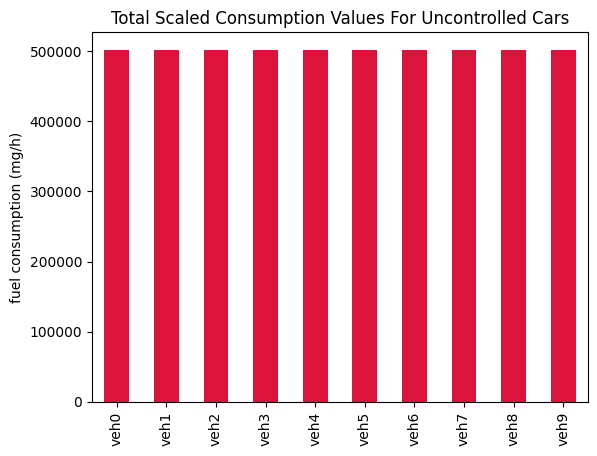

In [192]:
readCalculateAndPrintFuelConsumption_Normal(
    "emissionBaseValues_Uncontrolled.xml",
    "emissionScalingValues_Uncontrolled.xml",
    "Total Scaled Consumption Values For Uncontrolled Cars",
    5
)

veh0    480926.0778
veh1    480628.0596
veh2    480102.9146
veh3    482933.8926
veh4    481294.3384
veh5    478555.3772
veh6    475816.2680
veh7    473139.0166
veh8    472084.1036
veh9    469394.4368
dtype: float64


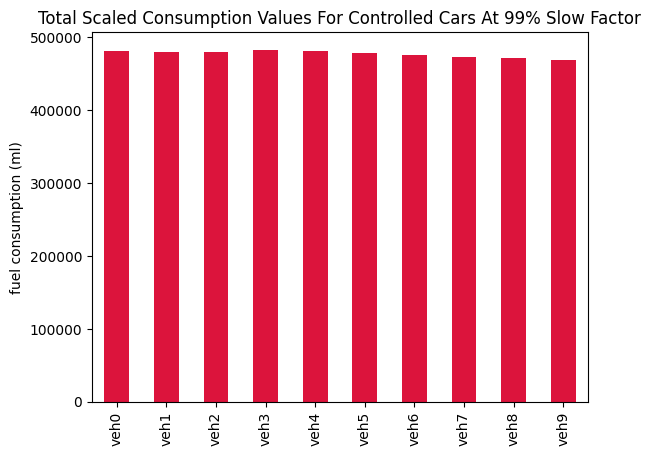

In [35]:
readCalculateAndPrintFuelConsumption_Normal(
    "emissionBaseValues_Controlled_SlowFactorAt_99_Percentage.xml",
    "emissionScalingValues_Controlled_SlowFactorAt_99_Percentage.xml",
    "Total Scaled Consumption Values For Controlled Cars At 99% Slow Factor",
    5
)

veh0    461601.8010
veh1    461596.9324
veh2    463141.2666
veh3    461728.0362
veh4    461612.7336
veh5    461618.0580
veh6    461623.3824
veh7    463249.7616
veh8    461569.3014
veh9    459044.8542
dtype: float64


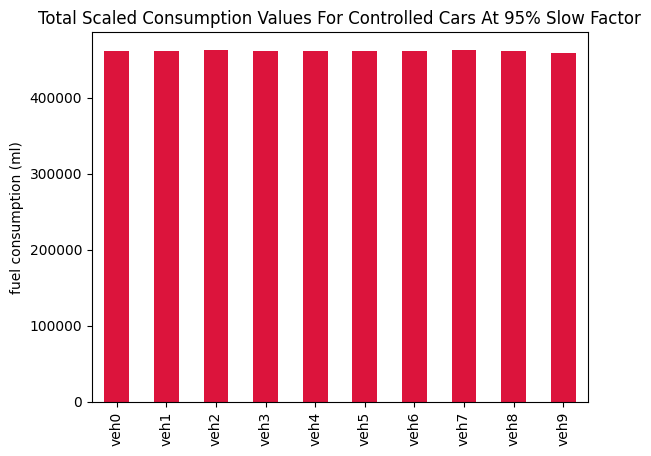

In [36]:
readCalculateAndPrintFuelConsumption_Normal(
    "emissionBaseValues_Controlled_SlowFactorAt_95_Percentage.xml",
    "emissionScalingValues_Controlled_SlowFactorAt_95_Percentage.xml",
    "Total Scaled Consumption Values For Controlled Cars At 95% Slow Factor",
    5
)

veh0    461069.1708
veh1    461064.2896
veh2    461210.1570
veh3    461074.8006
veh4    461080.0908
veh5    461085.4152
veh6    461090.7396
veh7    461236.7052
veh8    461110.8456
veh9    458768.5044
dtype: float64


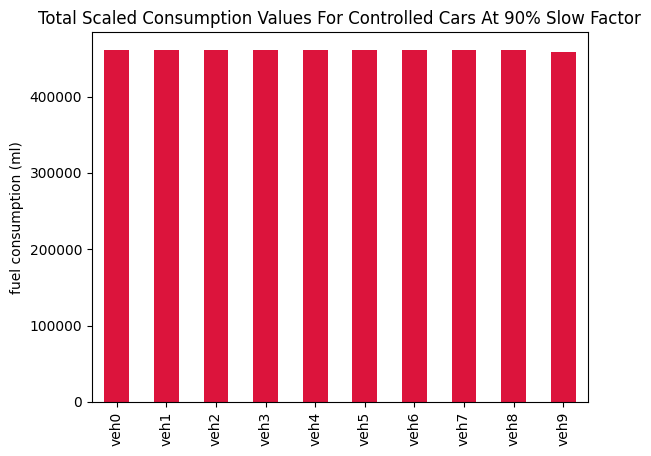

In [39]:
readCalculateAndPrintFuelConsumption_Normal(
    "emissionBaseValues_Controlled_SlowFactorAt_90_Percentage.xml",
    "emissionScalingValues_Controlled_SlowFactorAt_90_Percentage.xml",
    "Total Scaled Consumption Values For Controlled Cars At 90% Slow Factor",
    5
)

veh0    461848.2066
veh1    461843.3344
veh2    461919.0170
veh3    461853.8454
veh4    461859.1356
veh5    461864.4600
veh6    461869.7844
veh7    461945.5652
veh8    461887.2822
veh9    459158.0268
dtype: float64


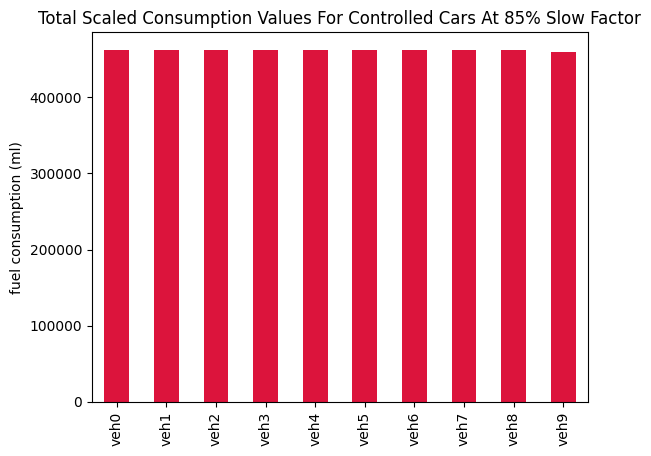

In [49]:
readCalculateAndPrintFuelConsumption_Normal(
    "emissionBaseValues_Controlled_SlowFactorAt_85_Percentage.xml",
    "emissionScalingValues_Controlled_SlowFactorAt_85_Percentage.xml",
    "Total Scaled Consumption Values For Controlled Cars At 85% Slow Factor",
    5
)

veh0    462655.7140
veh1    462650.8508
veh2    462719.0464
veh3    462661.3618
veh4    462666.6520
veh5    462671.9764
veh6    462677.3008
veh7    462732.6212
veh8    462694.9462
veh9    459561.7850
dtype: float64


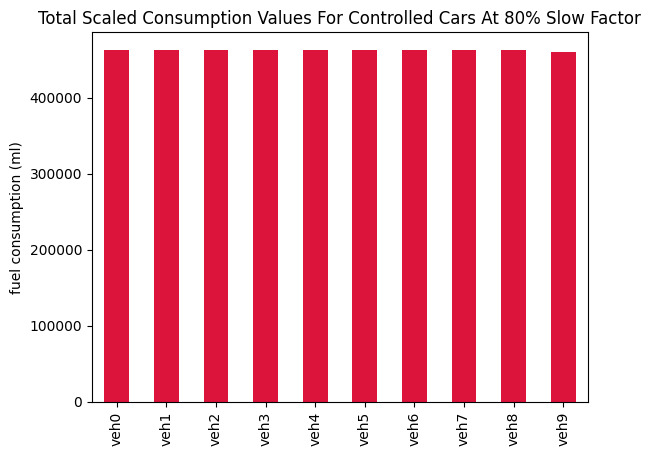

In [38]:
readCalculateAndPrintFuelConsumption_Normal(
    "emissionBaseValues_Controlled_SlowFactorAt_80_Percentage.xml",
    "emissionScalingValues_Controlled_SlowFactorAt_80_Percentage.xml",
    "Total Scaled Consumption Values For Controlled Cars At 80% Slow Factor",
    5
)

veh0    465189.4692
veh1    465184.5988
veh2    465189.8268
veh3    465195.1098
veh4    465200.4000
veh5    465205.7244
veh6    465211.0488
veh7    465237.4752
veh8    465231.1476
veh9    460828.6590
dtype: float64


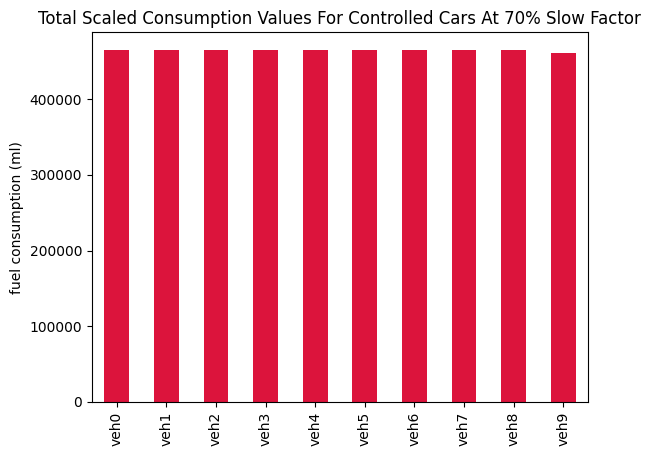

In [40]:
readCalculateAndPrintFuelConsumption_Normal(
    "emissionBaseValues_Controlled_SlowFactorAt_70_Percentage.xml",
    "emissionScalingValues_Controlled_SlowFactorAt_70_Percentage.xml",
    "Total Scaled Consumption Values For Controlled Cars At 70% Slow Factor",
    5
)

veh0    467416.3362
veh1    467411.1760
veh2    467416.4040
veh3    467421.6870
veh4    467426.9772
veh5    467432.3016
veh6    467437.6260
veh7    467447.6912
veh8    467466.8220
veh9    461941.9476
dtype: float64


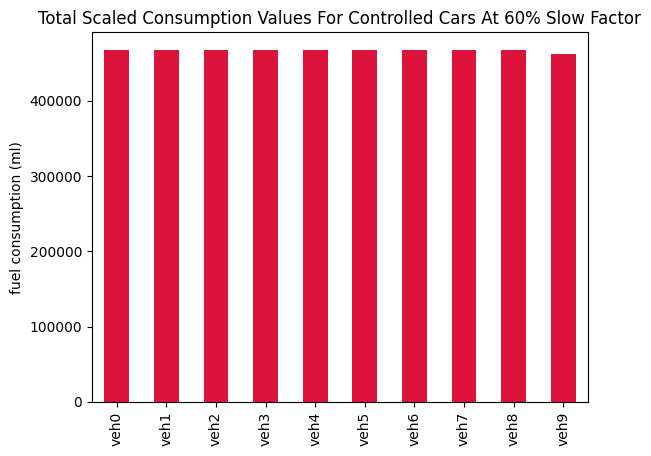

In [41]:
readCalculateAndPrintFuelConsumption_Normal(
    "emissionBaseValues_Controlled_SlowFactorAt_60_Percentage.xml",
    "emissionScalingValues_Controlled_SlowFactorAt_60_Percentage.xml",
    "Total Scaled Consumption Values For Controlled Cars At 60% Slow Factor",
    5
)

veh0    476404.3242
veh1    476410.2232
veh2    476407.5546
veh3    476413.2210
veh4    476418.4968
veh5    476423.8212
veh6    476429.1456
veh7    476396.8668
veh8    477759.3600
veh9    466447.7358
dtype: float64


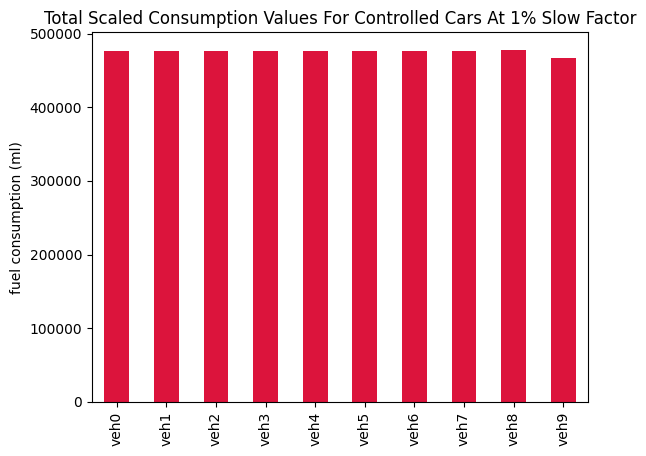

In [43]:
readCalculateAndPrintFuelConsumption_Normal(
    "emissionBaseValues_Controlled_SlowFactorAt_1_Percentage.xml",
    "emissionScalingValues_Controlled_SlowFactorAt_1_Percentage.xml",
    "Total Scaled Consumption Values For Controlled Cars At 1% Slow Factor",
    5
)

veh0    504183.504
veh1    504189.224
veh2    504155.410
veh3    504200.902
veh4    504206.780
veh5    504212.696
veh6    504218.612
veh7    504184.908
veh8    504240.952
veh9    502904.900
dtype: float64


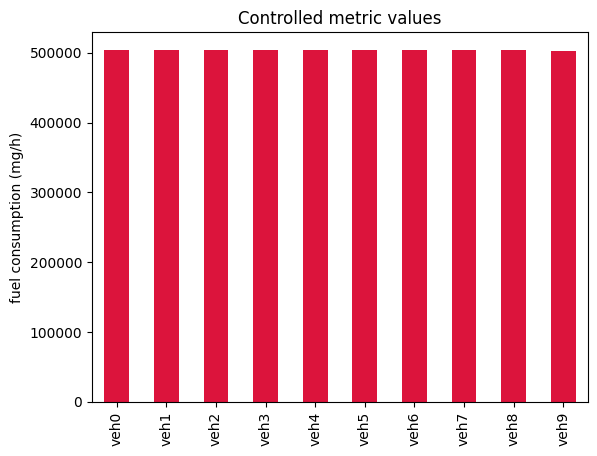

In [55]:
readCalculateAndPrintFuelConsumption_Normal(
    "emissionBaseValues_Controlled_Savings_At_0.xml",
    "emissionScalingValues_Controlled_Savings_At_0.xml",
    "Controlled metric values",
    5
)

veh0    501520.284
veh1    501520.284
veh2    501520.284
veh3    501520.284
veh4    501520.284
veh5    501520.284
veh6    501520.284
veh7    501520.284
veh8    501520.284
veh9    501520.284
dtype: float64


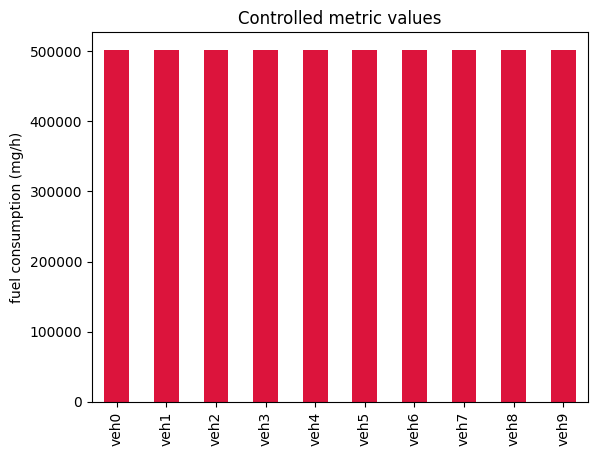

In [56]:
readCalculateAndPrintFuelConsumption_Normal(
    "emissionBaseValues_Uncontrolled_Savings_At_0.xml",
    "emissionScalingValues_Uncontrolled_Savings_At_0.xml",
    "Controlled metric values",
    5
)